In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Load data

In [2]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

data = data.dropna()

## Section 2: Item Description

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:xlabel='accuracy'>

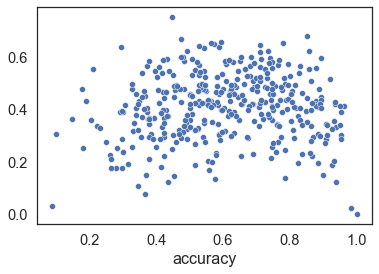

In [3]:
sum_scores = data.groupby('subject').accuracy.sum()
f = lambda x: np.corrcoef(sum_scores[x.subject], x.accuracy)[0,1]
a = data.groupby('item_id').apply(f).fillna(0)
b = data.groupby('item_id').accuracy.mean()
sns.scatterplot(x=b, y=a)

## Section 3: item invariance

## across distractor type

0.734375
0.734375


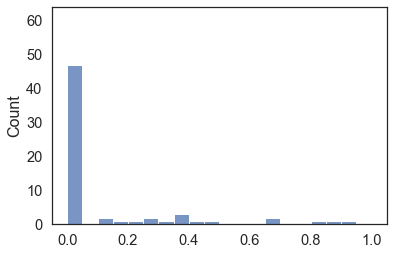

In [4]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import fdrcorrection

pivot = data.pivot_table('trial', ['item','accuracy'], 'distractor', aggfunc='count')
pvals = np.array([chi2_contingency(pivot.loc[i])[1] for i in np.unique(data.item)])
_, fdr = fdrcorrection(pvals)

print(np.mean(pvals < 0.05))
print(np.mean(fdr < 0.05))

ax = sns.histplot(pvals, bins=np.linspace(0,1,21));
ax.set(ylim=(0,64));

0.71875
0.703125


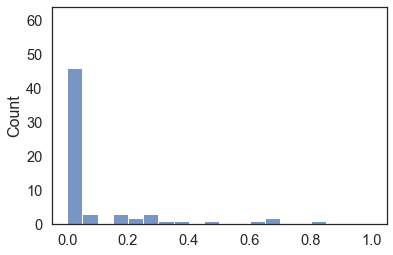

In [5]:
from statsmodels.api import Logit
from statsmodels.stats.multitest import fdrcorrection

sum_scores = data.groupby('subject').accuracy.agg(['sum','count'])

zscore = lambda x: (x - np.mean(x)) / np.std(x)

items = np.unique(data.item)
pvals = np.zeros_like(items, dtype=float)

for i, item in enumerate(items):
    
    ## Restrict.
    df = data.query(f'item == {item}')
    
    x1 = df.distractor.replace({'md':1, 'pd':0}).values
    x0 = np.ones_like(x1)
    
    ## Normalized sum scores.
    x2 = (sum_scores.loc[df.subject, 'sum'].values - df.accuracy.values)
    x2 /= sum_scores.loc[df.subject, 'count'].values - 1
    x2 = zscore(x2)
    
    ## Perform regression.
    X = np.column_stack([x0,x1,x2])
    y = df.accuracy.values
    fit = Logit(y, X).fit(disp=0)
    
    pvals[i] = fit.pvalues[1]
    
_, fdr = fdrcorrection(pvals)

print(np.mean(pvals < 0.05))
print(np.mean(fdr < 0.05))

ax = sns.histplot(pvals, bins=np.linspace(0,1,21));
ax.set(ylim=(0,64));

## across shape set

0.4375
0.34375


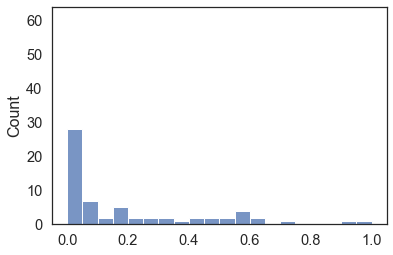

In [6]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import fdrcorrection

pivot = data.pivot_table('trial', ['item','accuracy'], 'shape_set', aggfunc='count')
pvals = np.array([chi2_contingency(pivot.loc[i])[1] for i in np.unique(data.item)])
_, fdr = fdrcorrection(pvals)

print(np.mean(pvals < 0.05))
print(np.mean(fdr < 0.05))

ax = sns.histplot(pvals, bins=np.linspace(0,1,21));
ax.set(ylim=(0,64));

0.484375
0.28125


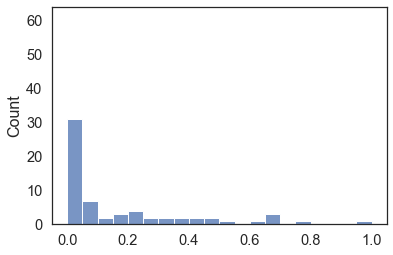

In [7]:
from statsmodels.api import Logit
from statsmodels.stats.multitest import fdrcorrection

sum_scores = data.groupby('subject').accuracy.agg(['sum','count'])

zscore = lambda x: (x - np.mean(x)) / np.std(x)

items = np.unique(data.item)
pvals = np.zeros_like(items, dtype=float)

for i, item in enumerate(items):
    
    ## Restrict.
    df = data.query(f'item == {item}')
    
    ## Normalized sum scores.
    x1 = (sum_scores.loc[df.subject, 'sum'].values - df.accuracy.values)
    x1 /= sum_scores.loc[df.subject, 'count'].values - 1
    x1 = zscore(x1)
    x0 = np.ones_like(x1)
    
    x2 = np.where(df.shape_set==2, 1, 0)
    x3 = np.where(df.shape_set==3, 1, 0) 
    
    ## Perform regression.
    X = np.column_stack([x0,x1,x2,x3])
    y = df.accuracy.values
    fit = Logit(y, X).fit(disp=0)
    
    f_test = fit.f_test([[0,0,1,0],[0,0,0,1]])
    pvals[i] = f_test.pvalue
    
_, fdr = fdrcorrection(pvals)

print(np.mean(pvals < 0.05))
print(np.mean(fdr < 0.05))

ax = sns.histplot(pvals, bins=np.linspace(0,1,21));
ax.set(ylim=(0,64));

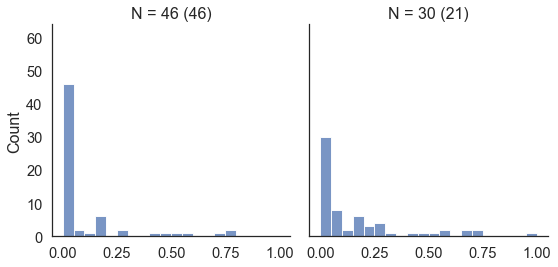

In [8]:
from statsmodels.api import Logit
from statsmodels.stats.multitest import fdrcorrection

sum_scores = data.groupby('subject').accuracy.agg(['sum','count'])

zscore = lambda x: (x - np.mean(x)) / np.std(x)

items = np.unique(data.item)
pvals = np.zeros((items.size, 2), dtype=float)


for i, item in enumerate(items):
    
    ## Restrict.
    df = data.query(f'item == {item}')
    
    ## Normalized sum scores.
    x0 = np.ones(len(df))
    x1 = (sum_scores.loc[df.subject, 'sum'].values - df.accuracy.values)
    x1 /= sum_scores.loc[df.subject, 'count'].values - 1
    x1 = zscore(x1)
    x2 = df.distractor.replace({'md':1, 'pd':0}).values
    x3 = np.where(df.shape_set==2, 1, 0)
    x4 = np.where(df.shape_set==3, 1, 0) 

    ## Perform regression.
    X = np.column_stack([x0,x1,x2,x3,x4])
    y = df.accuracy.values
    fit = Logit(y, X).fit(disp=0)
    
    pvals[i,0] = fit.pvalues[2]
    f_test = fit.f_test([[0,0,0,1,0],[0,0,0,0,1]])
    pvals[i,1] = f_test.pvalue
    
    
fdr = np.zeros_like(pvals)
_, fdr[:,0] = fdrcorrection(pvals[:,0])
_, fdr[:,1] = fdrcorrection(pvals[:,1])

fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
sns.histplot(pvals[:,0], bins=np.linspace(0,1,21), ax=axes[0])
sns.histplot(pvals[:,1], bins=np.linspace(0,1,21), ax=axes[1])
axes[0].set(ylim=(0,items.size), title='N = %s (%s)' %(sum(pvals[:,0] < 0.05), sum(fdr[:,0] < 0.05)))
axes[1].set(ylim=(0,items.size), title='N = %s (%s)' %(sum(pvals[:,1] < 0.05), sum(fdr[:,1] < 0.05)))

sns.despine()
plt.tight_layout()

[ 6 15 16 18 24 26 34 35 37 44 47 50 52 54 59 61 63 65 66 74 75]


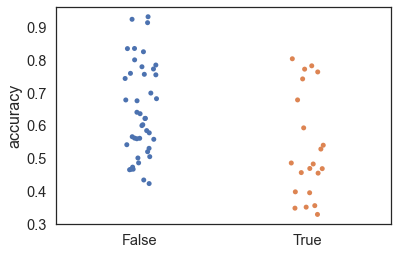

In [9]:
items = np.unique(data.item)[np.where(fdr[:,1] < 0.05)]
sns.stripplot(x=fdr[:,1] < 0.05, y=data.groupby('item').accuracy.mean())
print(items)

In [10]:
gb = data[data.item.isin(items)].groupby('item').accuracy.agg(['sum','count'])
gb['incorrect'] = gb['count'] - gb['sum']
gb

,sum,count,incorrect
item,,,
6,274.0,359,85.0
15,257.0,379,122.0
16,290.0,361,71.0
18,220.0,371,151.0
24,175.0,383,208.0
26,121.0,347,226.0
34,169.0,360,191.0
35,208.0,385,177.0
37,142.0,359,217.0


/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


61
0.3333333333333333
0.05


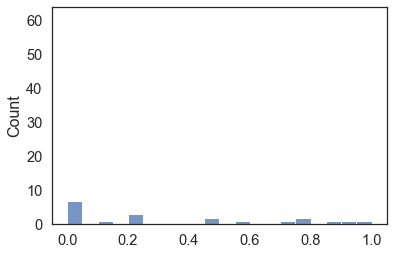

In [11]:
from scipy.stats import chi2
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.stats.multitest import fdrcorrection

sum_scores = data.groupby('subject').accuracy.agg(['sum','count'])

zscore = lambda x: (x - np.mean(x)) / np.std(x)

pvals = np.zeros_like(items, dtype=float) * np.nan

for i, item in enumerate(items):

    ## Restrict.
    df = data.query(f'item == {item} and choice > 0')

    ## Normalized sum scores.
    x0 = np.ones(len(df))
    x1 = (sum_scores.loc[df.subject, 'sum'].values - df.accuracy.values)
    x1 /= sum_scores.loc[df.subject, 'count'].values - 1
    x1 = zscore(x1)
    x2 = df.distractor.replace({'md':1, 'pd':0}).values
    x3 = np.where(df.shape_set==2, 1, 0)
    x4 = np.where(df.shape_set==3, 1, 0) 

    ## Perform regression.
    X = np.column_stack([x0,x1,x2,x3,x4])
    y = df.choice.values
    m1 = MNLogit(y, X[:,:-2]).fit(maxiter=10000, disp=0)
    if not m1.mle_retvals['converged']: 
        print(item)
        continue
    m2 = MNLogit(y, X).fit(maxiter=10000, disp=0)
    if not m2.mle_retvals['converged']: 
        print(item)
        continue

    df = m2.df_model - m1.df_model
    x = -2 * (m1.llf - m2.llf)
    pvals[i] = 1 - chi2(df).cdf(x)
    
_, fdr = fdrcorrection(pvals[~np.isnan(pvals)])

print(np.mean(pvals < 0.05))
print(np.mean(fdr < 0.05))

ax = sns.histplot(pvals, bins=np.linspace(0,1,21));
ax.set(ylim=(0,64));

In [12]:
items[pvals < 0.05]

array([16, 24, 26, 34, 35, 47, 52])

In [39]:
data.query('item==47').pivot_table('trial',['distractor','shape_set'],'choice',aggfunc='count').fillna(0)

choice                0.0  1.0  2.0  3.0
distractor shape_set                    
md         1           18   21   12    8
           2           37    9    8    3
           3           23   22    7    9
pd         1           37    7   22    4
           2           33    4   24    2
           3           20    8   19   12

In [41]:
## Restrict.
df = data.query(f'item == 52 and choice > 0')

## Normalized sum scores.
x0 = np.ones(len(df))
x1 = (sum_scores.loc[df.subject, 'sum'].values - df.accuracy.values)
x1 /= sum_scores.loc[df.subject, 'count'].values - 1
x1 = zscore(x1)
x2 = df.distractor.replace({'md':1, 'pd':0}).values
x3 = np.where(df.shape_set==2, 1, 0)
x4 = np.where(df.shape_set==3, 1, 0) 

## Perform regression.
X = np.column_stack([x0,x1,x2,x3,x4])
y = df.choice.values
m1 = MNLogit(y, X[:,:-2]).fit(maxiter=10000, disp=0)
m2 = MNLogit(y, X).fit(maxiter=10000, disp=0)
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      194
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 Sep 2021   Pseudo R-squ.:                 0.07073
Time:                        22:46:21   Log-Likelihood:                -206.09
converged:                       True   LL-Null:                       -221.78
Covariance Type:            nonrobust   LLR p-value:                 0.0001205
==============================================================================
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0034      0.347      2.894      0.004       0.324       1.683
x1            -0.1278      0.184     -0.696      0.486      -0.488       0.232
x2            -1.3978      0.364     -3.842      0.000      -2.111      -0.685
x3             0.0683      0.478      0.143      0.886      -0.868       1.004
x4            -1.0890      0.410     -2.655      0.008      -1.893      -0.285
------------------------------------------------------------------------------
       y=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0512      0.391      0.131      0.896      -0.715       0.818
x1            -0.0292      0.189     -0.155      0.877      -0.399       0.341
x2            -0.6654      0.374     -1.777      0.076      -1.399       0.069
x3             0.7104      0.490      1.450      0.147      -0.250       1.670
x4            -0.3735      0.422     -0.884      0.377      -1.201       0.454
==============================================================================
"""

#### notes

- item 16: pd is numerically unstable, ignore
- item 24: md/pd has a distractor type in ss2 that should be discarded. otherwise keep?
- item 26: md/pd has a distractor type in ss2 that should be discarded. otherwise keep?
- item 34: md/pd has a distractor type in ss3 that should be discarded. otherwise keep?
- item 35: not clear, but probably discard?
- item 47: seems like it's a mistake?
- item 52: md/pd has a distractor type in ss3 that should be discarded. otherwise keep?

## Section 4: planning

## strategies

#### (1) remove all flagged items

simply cannot too many

#### (2) collapse across distractors

seems more plausible to collapse across distractors than shapes. you've previous found that these are 0.8-0.9 correlated. collapsing across these at least brings you to 120 persons per item, and 192 items total. 

#### (3) collapse across shape sets

the other option is to collapse across shapes (after some exclusions?) and model distractors. this is 180 persons per item, and only 128 items.

maybe 3pl + perceptual category is sufficient. use 3pl model to basically identify those items with substantial misfit and remove them

#### addressing guessing

is it possible to extend the 1pl-guessing model to remove guessing level and instead include guessing level by ability? [this probably won't work because guessing likely be greater than 1/4]

maybe heterogeneity [doesn't do shit]

maybe exclusions of selective data? 10.1177/0146621614529646



In [ ]:
from statsmodels.api import Logit
np.random.seed(47404)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

theta = np.random.normal(0,1,1500)
beta  = np.linspace(-2,2,15)
gammas = [
    np.ones_like(beta) * 0.25,
    np.linspace(0,0.25,15)
]

fig, ax = plt.subplots(1,1,figsize=(6,4))

for gamma, color in zip(gammas, sns.color_palette(n_colors=2).as_hex()):

    for _ in range(10):
    
        alpha = []
        for b, g in zip(beta, gamma):

            mu = g + (1-g) * inv_logit(theta - b)
            y = np.random.binomial(1,mu)
            X = np.column_stack([np.ones_like(theta), theta])

            fit = Logit(y, X).fit(disp=False)
            alpha.append(fit.params[-1])

        sns.scatterplot(x=beta + np.random.normal(0,1e-1,15), y=alpha, color=color, ax=ax)